# RMSProp

在AdaGrad中，我们的学习率按照预定时间表$\mathcal{O}(t^{- \frac {1}{2}})$显著降低，这可能不是很理想的，但是作为预处理器，AdaGrad算法按坐标顺序的适应性是非常可取的

在AdaGrad中有:
$$s_t = s_{t-1} + g_t^2$$

它是没有规范化的，会导致$s_t$持续增大，在算法收敛的时候线性递增，解决这个问题的一种方法是$s_t/t$，对于$g_t$的合理分布来说，它将收敛。但是需要很长的时间，因为该流程记住了值的完整轨迹。

另外一种方法是使用Momentum里面的泄露平均值即：
$$
s_t \gets \gamma s_{t-1} + (1-\gamma)g_t^2\\
x_t \gets x_{t-1} - \frac {\eta} {\sqrt{s_t+\epsilon}} \odot g_t
$$

其中$\epsilon$设置为10e-6,防止除以零，鉴于这种扩展，我们就可以自由地设置学习率$\eta$，而不用考虑数据的尺度。

$$
\begin{aligned}
s_t & = (1-\gamma) g_t^2 + \gamma s_{t-1}\\
    & = (1-\gamma)(g_t^2 + \gamma g_{t-1}^2 + \gamma^2g_{t-2}^2 + \dots,)
\end{aligned}
$$

像momentum里面一样，我们使用$ 1+ \gamma + \gamma^2 + \gamma^3 + \dots = \frac {1}{1-\gamma} $，权重的总和也是为1的，观测值的半衰期为$ \gamma^{-1}$

Text(0.5, 0, 'time')

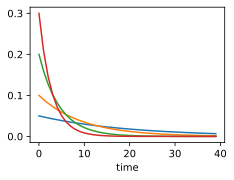

In [1]:
# 看看不同的\gamma对于s的影响
import math 
import torch as t
import sys
sys.path.append("../")
from pltutils import *

set_figsize()
gammas = [0.95,0.9,0.8,0.7]

for gamma in gammas:
    x = t.arange(40).detach().numpy()
    plt.plot(x,(1-gamma)*gamma**x,label=f'gamma = {gamma:.2f}')
plt.xlabel("time")

epoch 20, x1: -0.010599, x2: 0.000000


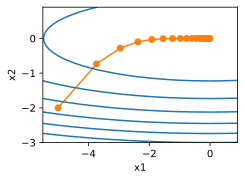

In [2]:
# 从零开始实现
def rmsprop_2d(x1,x2,s1,s2):
    g1,g2,eps = 0.2*x1,4*x2,1e-6
    s1 = gamma * s1 + (1-gamma) *g1**2
    s2 = gamma*s2 +(1-gamma) *g2**2
    x1 -= eta/math.sqrt(eps+ s1)* g1
    x2 -= eta/math.sqrt(eps+ s2)*g2
    return x1,x2,s1,s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

In [ ]:
# 神经网络中的RMSProp
# 将s_w s_b的初始状态都设置为0
def init_rmsprop_states(feature_dim):
    s_w = t.zeros((feature_dim,1))
    s_b = t.zeros(1)
    return (s_w,s_b)
# 真正的RMSProp算法
def rmsprop(params,states,hyperparams):
    gamma,eps = hyperparams["gamma"] ,1e-6
    for p ,s in zip(params,states):
        with t.no_grad():
            s[:] = gamma* s +(1-gamma) *t.square(p.grad)
            p [:] -= hyperparams["lr"] *p.grad /t.sqrt(s+eps)
        
        p.grad.data.zero_()
        

# 总结
AdaGrad算法是为了解决样本稀疏的情况下如何权衡学习率的问题

RMSProp优化了AdaGrad，防止在样本后面的时间步学习率过小的问题，因为上面证明了它的展开式权重和是1，一句话：使用泄露平均值解决了数据尺度(scale)的问题。